In [2]:
import pandas as pd

### Geographical Analysis

In [3]:
job_listings_df = pd.read_csv("./data/linkedin_job_postings.csv")

In [4]:
usa_df = job_listings_df[job_listings_df["search_country"] == "United States"]
len(usa_df)

1149342

In [140]:
defective = []
def get_state(row):
    try:
        state = row["job_location"].split(", ")[1]
        if len(state) == 2:
            return state
        else:
            defective.append(state)
    except:
        return None

usa_df["state"] = usa_df.apply(get_state, axis=1)

C:\Users\ustym\AppData\Local\Temp\ipykernel_1496\1791898811.py:12: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



In [7]:
import plotly.express as px

In [144]:
state_data = usa_df["state"].value_counts()
state_data = state_data.to_frame().reset_index().rename(columns= {"count": 'NumOfVacancies'})

fig = px.choropleth(state_data, locations='state',
                    locationmode="USA-states", color='NumOfVacancies', 
                    scope="usa", title="Number of LinkedIn Job Postings 2024",
                    height=1000, width=1500)
fig.update_layout(
    title={
        'text': "Number of LinkedIn Job Postings per State 2024",
        'font': {'size': 28}
    }
)

fig.show()

In [146]:
states_population_df = pd.read_csv("./data/US States Ranked by Population 2024.csv")[["US State", "Population 2024"]]

def get_state_relative(state):
    population = states_population_df[states_population_df["US State"] == state]["Population 2024"].iloc[0]
    vacancies = state_data[state_data["state"] == state]["NumOfVacancies"].iloc[0]
    return vacancies/population

state_data["vacancies per capita"] = state_data["state"].apply(get_state_relative)

In [147]:
without_dc = state_data[state_data['state'] != "DC"]
fig = px.choropleth(without_dc, locations='state',
                    locationmode="USA-states", color='vacancies per capita', 
                    scope="usa", title="Vacancies on LinkedIn per capita",
                    height=1000, width=1500)

fig.update_layout(
    title={
        'font': {'size': 28}
    }
)

fig.show()

In [ ]:
states_unemployment_df = pd.read_csv("./data/State_Unemployment_Rates.csv")[["State", "Unemployment Rate"]]
fig = px.choropleth(states_unemployment_df, locations='State',
                    locationmode="USA-states", color='Unemployment Rate', 
                    scope="usa", title="Unemployment Rate by State(%)",
                    height=1000, width=1500)

fig.update_layout(
    title={
        'font': {'size': 28}
    }
)
fig.show()

ValueError: The first argument to the plotly.graph_objs.Choropleth
constructor must be a dict or
an instance of :class:`plotly.graph_objs.Choropleth`

### Occupation Type Analysis

In [100]:
import json
import textwrap
import seaborn as sns

In [101]:
import matplotlib.pyplot as plt

In [94]:
with open("./result_mini_llm_v0.json", "r") as f:
    job_titles_dct = json.load(f)

usa_df["equivalent job title"] = usa_df["job_title"].apply(lambda x: job_titles_dct[x])

C:\Users\ustym\AppData\Local\Temp\ipykernel_1496\2428763847.py:4: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



In [102]:
def wrap_labels(ax, width, break_long_words=False):
    labels = []
    for label in ax.get_yticklabels():
        text = label.get_text()
        labels.append(textwrap.fill(text, width=width,
                      break_long_words=break_long_words))
    ax.set_yticklabels(labels, rotation=0)

def get_state_most_popular_jobs(df, state, how_many = 10):
    position_stats = df[df["state"] == state]["equivalent job title"].value_counts()[:how_many]
    return position_stats.to_frame().reset_index().rename(columns= {0: 'number'})

states_list = ["CA", "TX", "NY", "FL"]

C:\Users\ustym\AppData\Local\Temp\ipykernel_1496\3862227870.py:20: FutureWarning:



Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.


C:\Users\ustym\AppData\Local\Temp\ipykernel_1496\1932443973.py:7: UserWarning:

set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.

C:\Users\ustym\AppData\Local\Temp\ipykernel_1496\3862227870.py:20: FutureWarning:



Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.


C:\Users\ustym\AppData\Local\Temp\ipykernel_1496\1932443973.py:7: UserWarning:

set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.

C:\Users\ustym\AppData\Local\Temp\ipykernel_1496\3862227870.py:20: FutureWarning:



Passing `palette` w

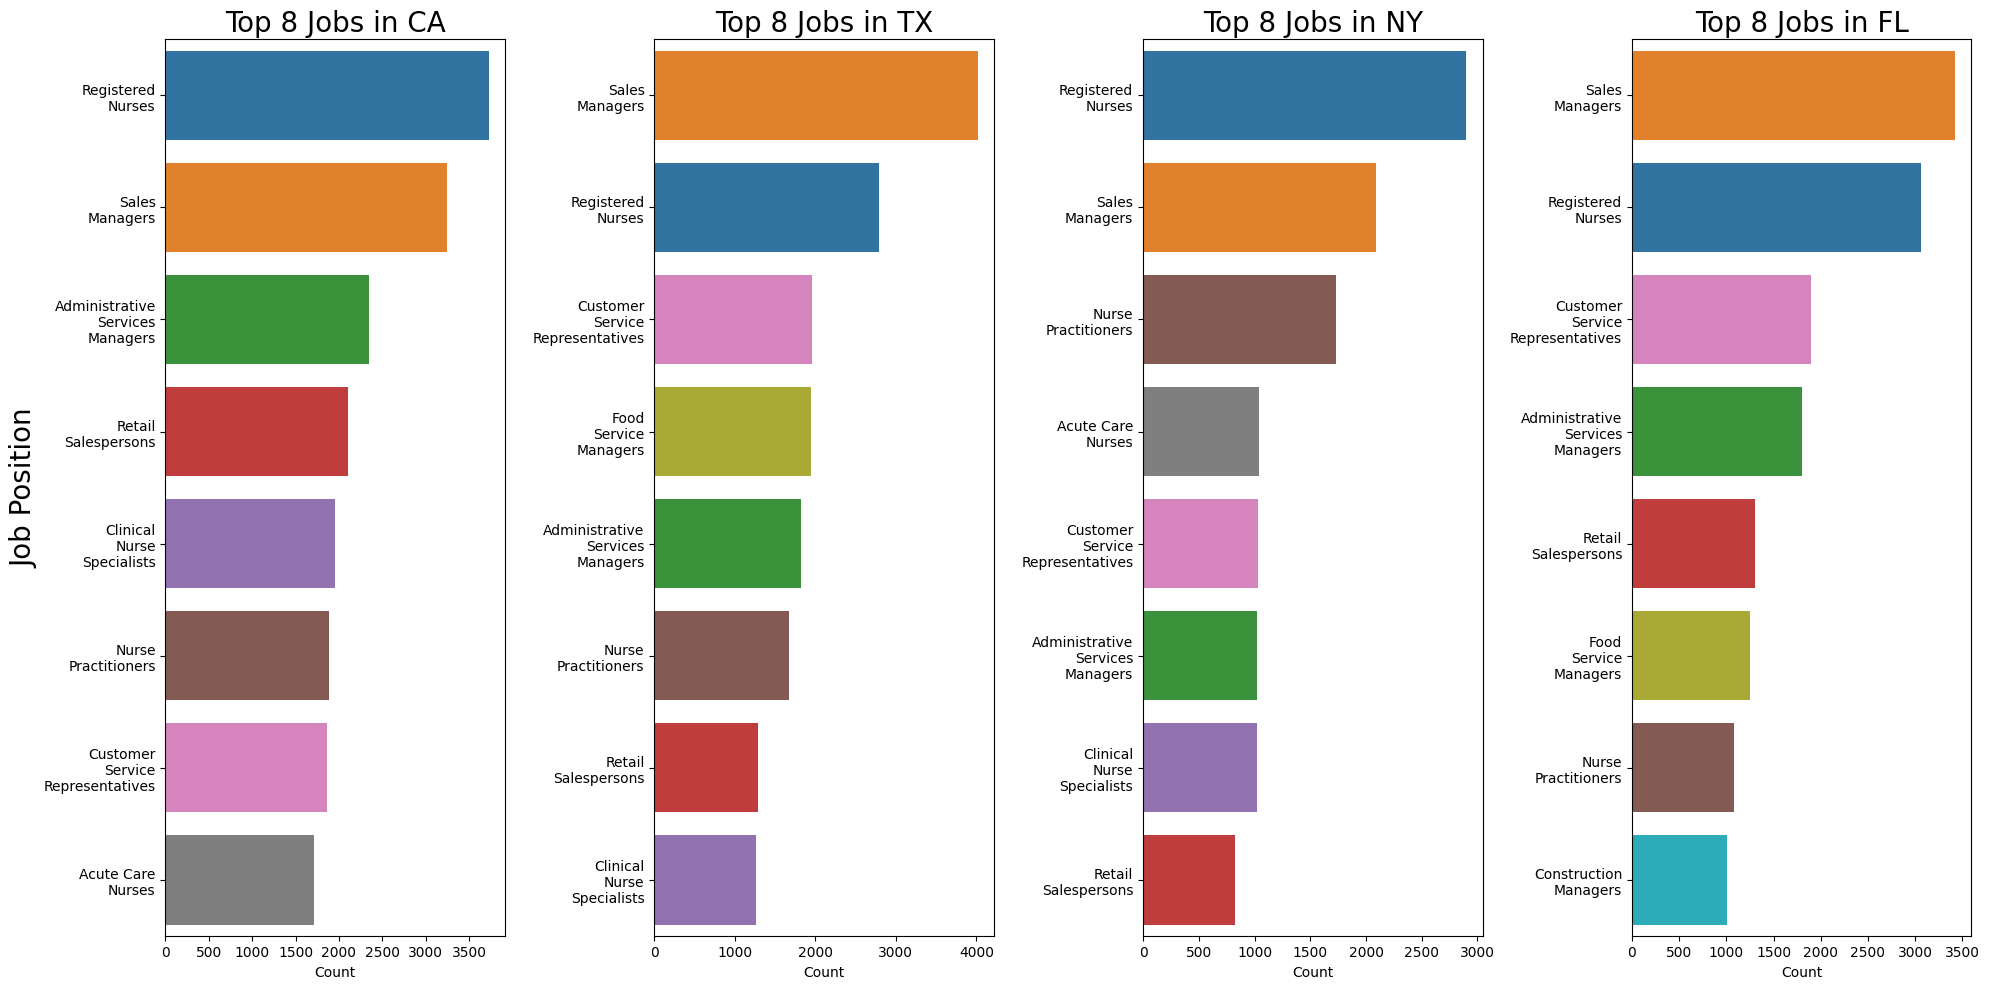

In [152]:
n_jobs = 8
top_jobs = pd.DataFrame()

for state in states_list:
    state_df = get_state_most_popular_jobs(usa_df, state, n_jobs)
    state_df['state'] = state  # Add state column for identification
    top_jobs = pd.concat([top_jobs, state_df])

top_jobs_list = list(top_jobs['equivalent job title'].unique())
palette = sns.color_palette(None, len(top_jobs_list))
jobs_colors = {}

for i, col in enumerate(palette):
    jobs_colors[top_jobs_list[i]] = col

fig, axes = plt.subplots(nrows=1, ncols=4, figsize=(20, 10))
for i, state in enumerate(states_list):
    ax = axes[i]
    state_jobs = top_jobs[top_jobs['state'] == state]
    sns.barplot(
        data=state_jobs,
        y='equivalent job title',
        x='count',
        palette=[jobs_colors[job] for job in state_jobs['equivalent job title']],
        ax=ax
    )
    wrap_labels(ax, 10)
    ax.set_title(f'Top {n_jobs} Jobs in {state}', {'fontsize': 20})
    ax.set_xlabel('Count')
    ax.set_ylabel('' if i > 0 else 'Job Position', {'fontsize': 20})

plt.tight_layout()
plt.show()

### Education level requirements

In [105]:
equ_req_df = pd.read_csv("education_levels.csv")

In [107]:
usa_df_full = pd.merge(usa_df, equ_req_df, how='inner', on='job_link')

In [108]:
usa_df_full.head(3)

,job_link,last_processed_time,got_summary,got_ner,is_being_worked,job_title,company,job_location,first_seen,search_city,search_country,search_position,job_level,job_type,state,equivalent job title,Unnamed: 0,edu_req
0,https://www.linkedin.com/jobs/view/account-exe...,2024-01-21 07:12:29.00256+00,t,t,f,Account Executive - Dispensing (NorCal/Norther...,BD,"San Diego, CA",2024-01-15,Coronado,United States,Color Maker,Mid senior,Onsite,CA,"Property, Real Estate, and Community Associati...",204910,bachelor_degree
1,https://www.linkedin.com/jobs/view/registered-...,2024-01-21 07:39:58.88137+00,t,t,f,Registered Nurse - RN Care Manager,Trinity Health MI,"Norton Shores, MI",2024-01-14,Grand Haven,United States,Director Nursing Service,Mid senior,Onsite,MI,Registered Nurses,933222,bachelor_degree
2,https://www.linkedin.com/jobs/view/restaurant-...,2024-01-21 07:40:00.251126+00,t,t,f,RESTAURANT SUPERVISOR - THE FORKLIFT,Wasatch Adaptive Sports,"Sandy, UT",2024-01-14,Tooele,United States,Stand-In,Mid senior,Onsite,UT,First-Line Supervisors of Food Preparation and...,962784,high_school


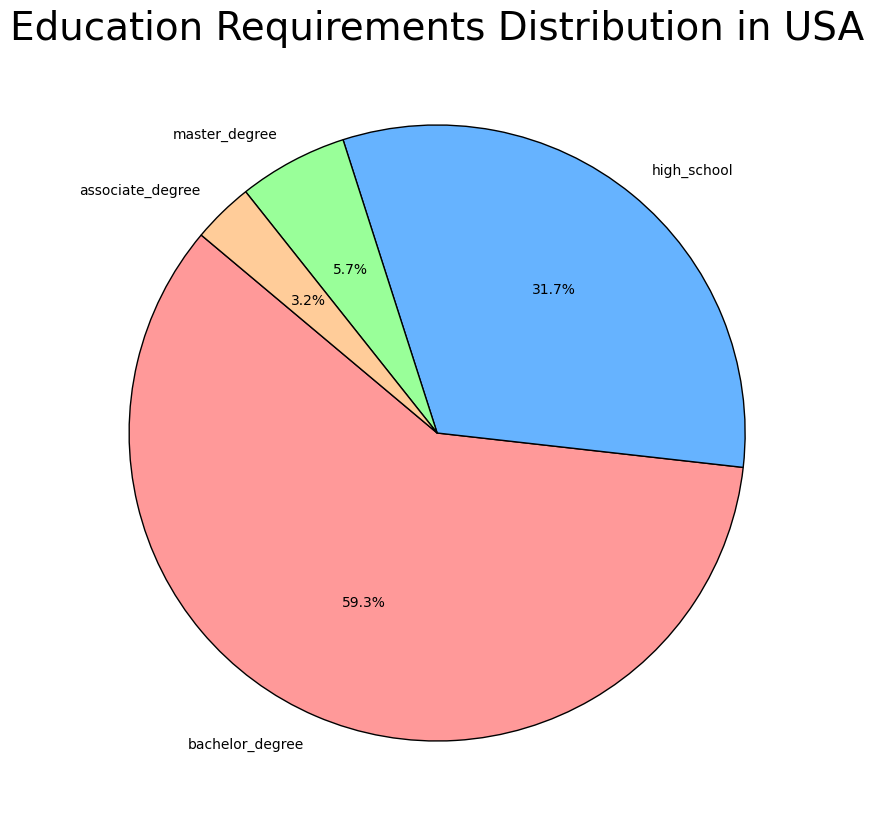

In [154]:
country = usa_df_full["edu_req"].value_counts()[:4]
def autopct_func(pct):
    return f'{pct:.1f}%' if pct >= 2 else ''

plt.figure(figsize=(10, 10))
plt.pie(
    country.values,
    labels=country.index,
    autopct=autopct_func,
    startangle=140,
    colors=['#ff9999','#66b3ff','#99ff99','#ffcc99'],
    wedgeprops={'edgecolor': 'black'}
)
plt.title("Education Requirements Distribution in USA", {'fontsize': 28})
plt.show()

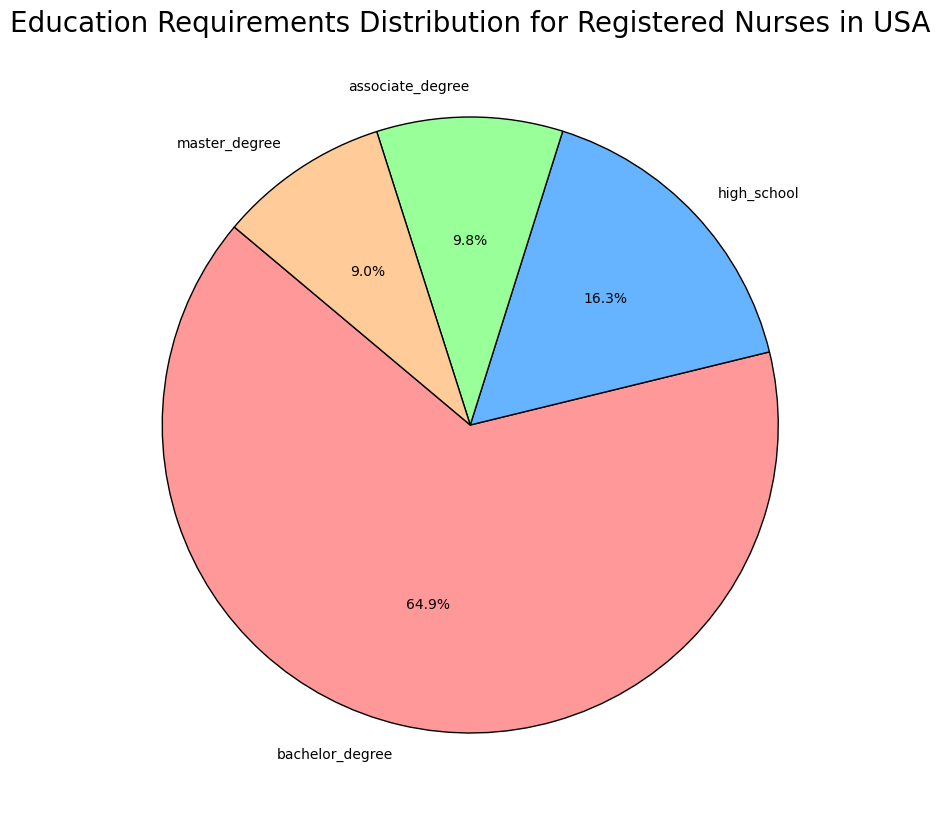

In [165]:
education = usa_df_full[usa_df_full["equivalent job title"] == "Registered Nurses"]["edu_req"].value_counts()[:4]

plt.figure(figsize=(10, 10))
plt.pie(
    education.values,
    labels=education.index,
    autopct=autopct_func,
    startangle=140,
    colors=['#ff9999','#66b3ff','#99ff99','#ffcc99'],
    wedgeprops={'edgecolor': 'black'}
)
plt.title("Education Requirements Distribution for Registered Nurses in USA", {'fontsize': 20})
plt.show()

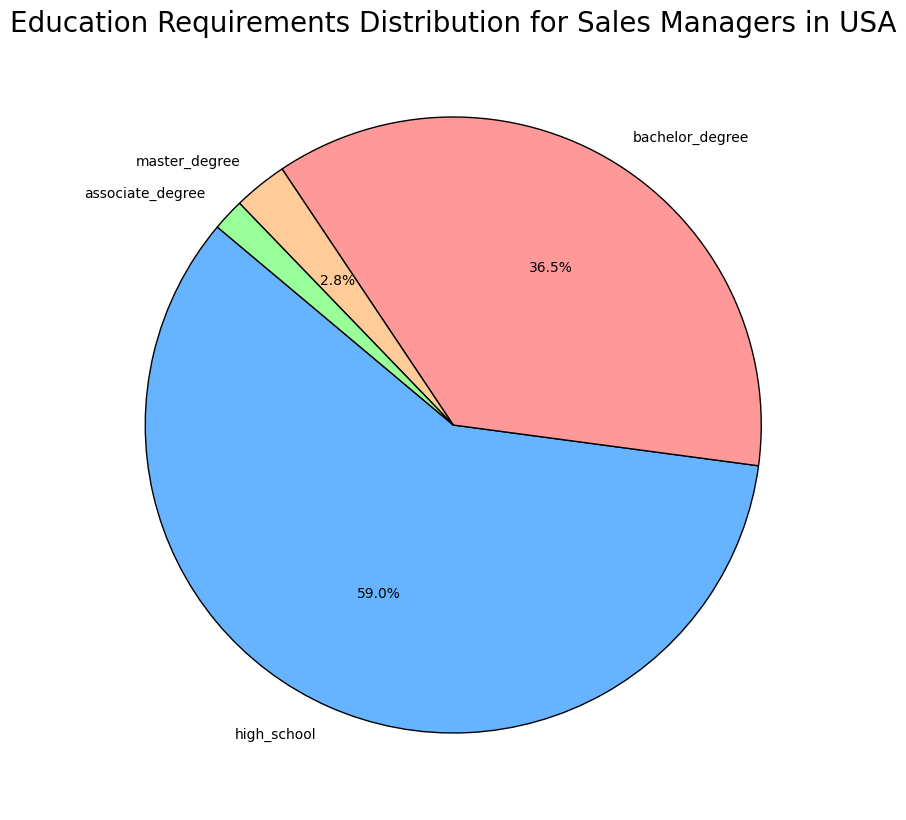

In [169]:
education = usa_df_full[usa_df_full["equivalent job title"] == "Sales Managers"]["edu_req"].value_counts()[:4]


plt.figure(figsize=(10, 10))
plt.pie(
    education.values,
    labels=education.index,
    autopct=autopct_func,
    startangle=140,
    colors=['#66b3ff', '#ff9999', '#ffcc99', '#99ff99'],
    wedgeprops={'edgecolor': 'black'}
)
plt.title("Education Requirements Distribution for Sales Managers in USA", {'fontsize': 20})
plt.show()

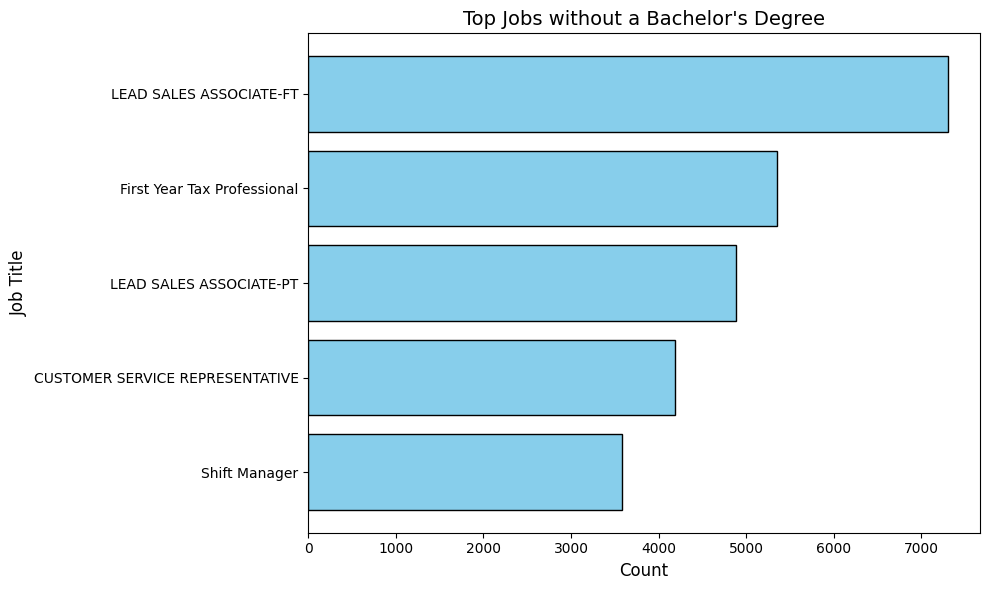

In [128]:
filtered_jobs = usa_df_full[
    (usa_df_full['edu_req'] == 'high_school') | (usa_df_full['edu_req'] == 'no_education')
]
job_counts = filtered_jobs['job_title'].value_counts()
top_jobs = job_counts.head(5)


plt.figure(figsize=(10, 6))
plt.barh(top_jobs.index, top_jobs.values, color='skyblue', edgecolor='black')
plt.title("Top Jobs without a Bachelor's Degree", fontsize=14)
plt.xlabel("Count", fontsize=12)
plt.ylabel("Job Title", fontsize=12)
plt.gca().invert_yaxis()  # Invert y-axis for better readability
plt.tight_layout()
plt.show()

In [170]:
usa_df_full.head(3)

,job_link,last_processed_time,got_summary,got_ner,is_being_worked,job_title,company,job_location,first_seen,search_city,search_country,search_position,job_level,job_type,state,equivalent job title,Unnamed: 0,edu_req
0,https://www.linkedin.com/jobs/view/account-exe...,2024-01-21 07:12:29.00256+00,t,t,f,Account Executive - Dispensing (NorCal/Norther...,BD,"San Diego, CA",2024-01-15,Coronado,United States,Color Maker,Mid senior,Onsite,CA,"Property, Real Estate, and Community Associati...",204910,bachelor_degree
1,https://www.linkedin.com/jobs/view/registered-...,2024-01-21 07:39:58.88137+00,t,t,f,Registered Nurse - RN Care Manager,Trinity Health MI,"Norton Shores, MI",2024-01-14,Grand Haven,United States,Director Nursing Service,Mid senior,Onsite,MI,Registered Nurses,933222,bachelor_degree
2,https://www.linkedin.com/jobs/view/restaurant-...,2024-01-21 07:40:00.251126+00,t,t,f,RESTAURANT SUPERVISOR - THE FORKLIFT,Wasatch Adaptive Sports,"Sandy, UT",2024-01-14,Tooele,United States,Stand-In,Mid senior,Onsite,UT,First-Line Supervisors of Food Preparation and...,962784,high_school


In [176]:
usa_df_cut = usa_df_full[['job_link', 'company', 'state',
       'equivalent job title', 'edu_req']]

usa_df_cut.head(10)

,job_link,company,state,equivalent job title,edu_req
0,https://www.linkedin.com/jobs/view/account-exe...,BD,CA,"Property, Real Estate, and Community Associati...",bachelor_degree
1,https://www.linkedin.com/jobs/view/registered-...,Trinity Health MI,MI,Registered Nurses,bachelor_degree
2,https://www.linkedin.com/jobs/view/restaurant-...,Wasatch Adaptive Sports,UT,First-Line Supervisors of Food Preparation and...,high_school
3,https://www.linkedin.com/jobs/view/independent...,Howard Hanna | Rand Realty,NJ,Real Estate Sales Agents,bachelor_degree
4,https://www.linkedin.com/jobs/view/registered-...,Trinity Health MI,MI,Registered Nurses,associate_degree
5,https://www.linkedin.com/jobs/view/part-time-h...,Creative Financial Staffing (CFS),NY,"Human Resources Assistants, Except Payroll and...",master_degree
6,https://www.linkedin.com/jobs/view/special-age...,Federal Bureau of Investigation (FBI),None,Paralegals and Legal Assistants,bachelor_degree
7,https://www.linkedin.com/jobs/view/manager-sit...,ICON plc,TN,Facilities Managers,high_school
8,https://www.linkedin.com/jobs/view/assistant-v...,RWJBarnabas Health,NJ,Physical Therapist Assistants,bachelor_degree
9,https://www.linkedin.com/jobs/view/control-sys...,Olsson,NE,Quality Control Systems Managers,bachelor_degree


In [179]:
usa_df_cut.to_csv("usa_jobs_processed.csv", index=0)

### States Ranking

In [ ]:
import random as rd

In [264]:
states_list = list(usa_df_cut["state"].unique())

def normalize_dict(data):
    values = [v for v in data.values() if isinstance(v, (int, float))]
    if not values:
        return data

    min_val = min(values)
    max_val = max(values)

    return {k: (v - min_val) / (max_val - min_val) if isinstance(v, (int, float)) else v for k, v in data.items()}

def get_states_score_for_jobs_list(df : pd.DataFrame, job_title_list):
    total_states_jobs = df.groupby(by = "state").count()["job_link"]
    
    df = df[df["equivalent job title"].isin(job_title_list)]
    results = dict(df.groupby(by = ["state", "equivalent job title"]).count()['job_link'])
    result_dct = {}
    
    # NOTE: i should be replaced by relevant score for each job. 
    for state in states_list:
        result_dct[state] = 0
        for i, job in enumerate(job_title_list):
            if results.get(tuple([state, job])):
                result_dct[state] += (len(job_title_list) - i) * results[tuple([state, job])] / total_states_jobs[state]
    return normalize_dict(result_dct)

In [413]:
top_job_titles = rd.sample(list(usa_df_cut["equivalent job title"].unique()), 10)
result_dict = get_states_score_for_jobs_list(usa_df_cut, top_job_titles)
result_score_df = pd.DataFrame(list(result_dict.items()), columns=['state', 'score'])

In [414]:
fig = px.choropleth(result_score_df, locations='state',
                    locationmode="USA-states", color='score', 
                    scope="usa", title="Attractiveness of the each state",
                    height=500, width=1000)

fig.update_layout(
    title={
        'font': {'size': 28}
    }
)
fig.show()

top_job_titles

['Chemistry Teachers, Postsecondary',
 'Police Identification and Records Officers',
 'Insulation Workers, Floor, Ceiling, and Wall',
 'Special Education Teachers, Kindergarten',
 'Civil Engineers',
 'Marriage and Family Therapists',
 'Installation, Maintenance, and Repair Workers, All Other',
 'Weighers, Measurers, Checkers, and Samplers, Recordkeeping',
 'Infantry Officers',
 'Geodetic Surveyors']

### Education statistics for Jobs

In [299]:
usa_df_cut.head(3)

,job_link,company,state,equivalent job title,edu_req
0,https://www.linkedin.com/jobs/view/account-exe...,BD,CA,"Property, Real Estate, and Community Associati...",bachelor_degree
1,https://www.linkedin.com/jobs/view/registered-...,Trinity Health MI,MI,Registered Nurses,bachelor_degree
2,https://www.linkedin.com/jobs/view/restaurant-...,Wasatch Adaptive Sports,UT,First-Line Supervisors of Food Preparation and...,high_school


In [411]:
top_job_titles = rd.sample(list(usa_df_cut["equivalent job title"].unique()), 5)
df = usa_df_cut[usa_df_cut["equivalent job title"].isin(top_job_titles)][["equivalent job title", "edu_req"]]

jobs_edu_dist = {}

for i, job in enumerate(top_job_titles):
    jobs_edu_dist[job] = df[df["equivalent job title"] == job]["edu_req"].value_counts()

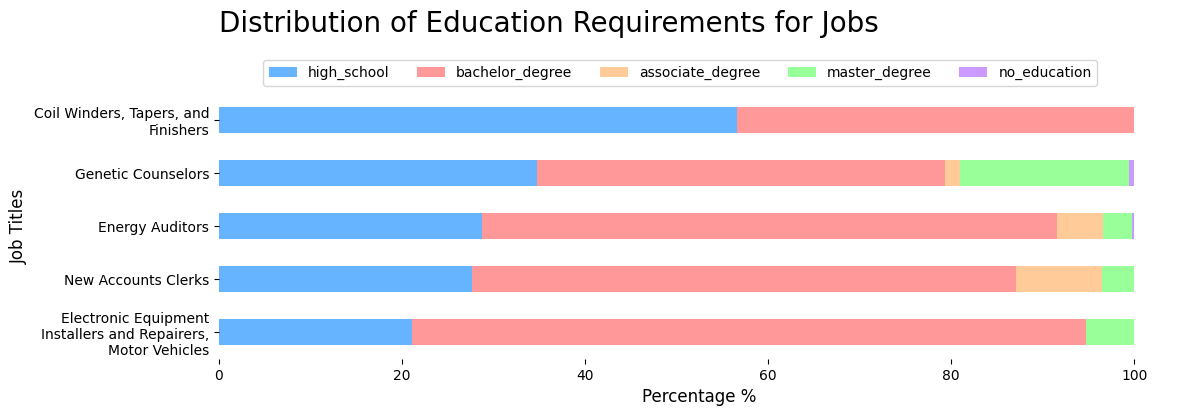

In [427]:
df = pd.DataFrame(jobs_edu_dist).fillna(0).T
df_normalized = df.div(df.sum(axis=1), axis=0) * 100
df_sorted = df_normalized.sort_values(by='high_school', ascending=True)

colors = ['#66b3ff', '#ff9999', '#ffcc99', '#99ff99', '#cc99ff', '#ffa64d']
list_categories = ['high_school', 'bachelor_degree', 'associate_degree', 'master_degree', 'no_education', 'vocational']
order = []
for i in list_categories:
    if i in list(df_sorted.columns):
        order.append(i)
df_sorted = df_sorted[order]

fig, ax = plt.subplots(figsize=(12, 5))
df_sorted.plot(kind='barh', stacked=True, ax=ax, color=colors)

ax.set_xlabel('Percentage %', fontdict={"size": 12})
ax.set_ylabel('Job Titles', fontdict={"size": 12})
ax.set_title('Distribution of Education Requirements for Jobs', y = 1.2, fontdict={"size": 20}, loc = "left")
wrap_labels(ax, 30)

handles, labels = ax.get_legend_handles_labels()
plt.legend(handles, labels, loc='upper center', bbox_to_anchor=(0.48, 1.15), ncol=len(labels), alignment = "left")
plt.tight_layout(rect=[0, 0, 1, 0.9])
plt.box(False)
plt.show()

In [429]:
import plotly.graph_objects as go

In [ ]:
def get_education_req_plot_for_jobs_list(df: pd.DataFrame, job_list: list):
    # Filter Dataframe
    df = df[df["equivalent job title"].isin(job_list)][
        ["equivalent job title", "edu_req"]
    ]
    jobs_edu_dist = {}
    for job in job_list:
        jobs_edu_dist[job] = df[df["equivalent job title"] == job][
            "edu_req"
        ].value_counts()

    # Prepare data for plotting
    df = pd.DataFrame(jobs_edu_dist).fillna(0).T
    df_normalized = df.div(df.sum(axis=1), axis=0) * 100
    df_sorted = df_normalized.sort_values(by="high_school", ascending=True)
    colors = ["#66b3ff", "#ff9999", "#ffcc99", "#99ff99", "#cc99ff", "#ffa64d"]
    list_categories = [
        "high_school",
        "bachelor_degree",
        "associate_degree",
        "master_degree",
        "no_education",
        "vocational",
    ]
    order = [category for category in list_categories if category in df_sorted.columns]
    df_sorted = df_sorted[order]

    # Create plotly figure
    fig = go.Figure()

    for i, category in enumerate(order):
        fig.add_trace(
            go.Bar(
                y=df_sorted.index,
                x=df_sorted[category],
                name=category.replace("_", " ").title(),
                orientation="h",
                marker=dict(color=colors[i]),
            )
        )

    # Update layout
    fig.update_layout(
        barmode="stack",
        title={
            "text": "Distribution of Education Requirements for Jobs",
            "y": 0.98,
            "x": 0.01,
            "xanchor": "left",
            "yanchor": "top",
            "font": {"size": 25},
        },
        xaxis_title="Percentage %",
        yaxis_title="Job Titles",
        xaxis=dict(tickformat=".0f"),
        legend=dict(
            orientation="h",
            x=0.01,
            y=1.1,
            xanchor="left",
        ),
        margin=dict(l=100, r=20, t=90, b=50),
        height=600,
        legend_traceorder="reversed"
    )

    return fig

In [458]:
get_education_req_plot_for_jobs_list(usa_df_cut, top_job_titles)